In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical
from data import data_dirs as data_env, get_label_with_context

from model import (
    LinkNet34,
    accuracy_segmentation, tensorboard_cb, 
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

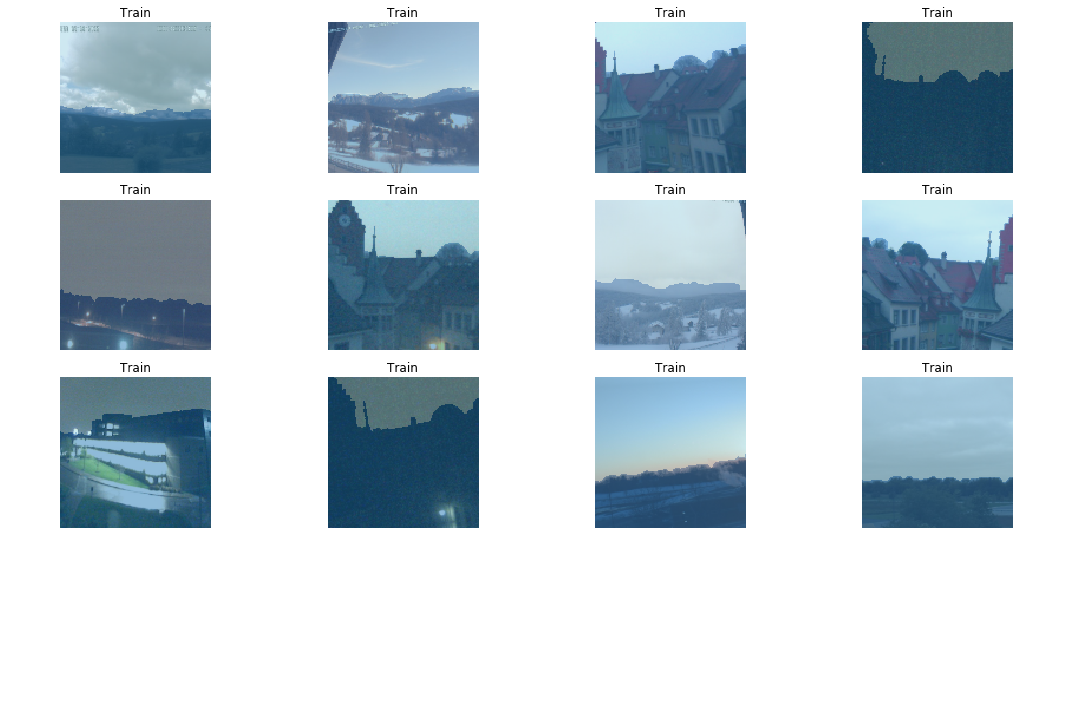

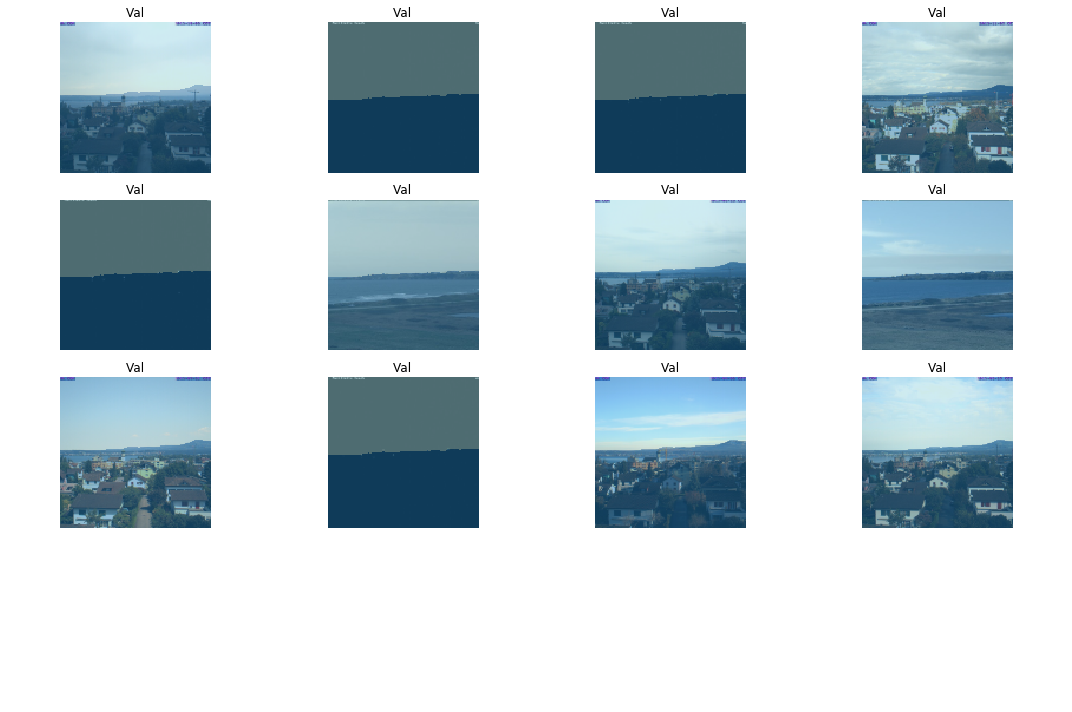

In [2]:
sizes = 128

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train", "val")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms()
                  , size=sizes, tfm_y=True)
    .databunch(bs=12)
    .normalize(imagenet_stats)
)
classes = train_data.c

train_data.show_batch(figsize=(15,10), title="Train")
train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [3]:
model = LinkNet34(num_classes=classes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()
learner.metrics = [accuracy_segmentation]

learner.freeze_to(1)

epoch,train_loss,valid_loss,accuracy_segmentation,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E+00
Min loss divided by 10: 3.31E-01


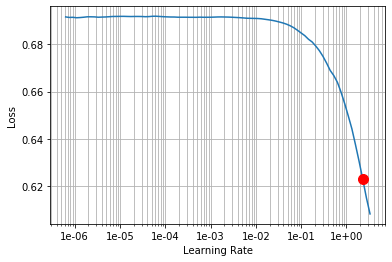

In [4]:
learner.lr_find()
learner.recorder.plot(suggestion=True, show_grid=True)

In [5]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="linknet34_ocp_upsmplT_s128_mlr5e1")

In [ ]:
learner.fit_one_cycle(50, max_lr=1e-01, callbacks=[tb_callback(learner)])
learner.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,accuracy_segmentation,time
0,0.500357,0.486952,0.954629,00:49
1,0.373718,0.363477,0.949503,00:49
2,0.258944,0.264367,0.949516,00:49
3,0.175611,0.193576,0.952464,00:49
4,0.124758,0.154579,0.956793,00:49
5,0.098351,0.143582,0.953180,00:49
6,0.085448,0.209197,0.918344,00:49
7,0.085958,0.139329,0.951684,00:50


profiler execution failed


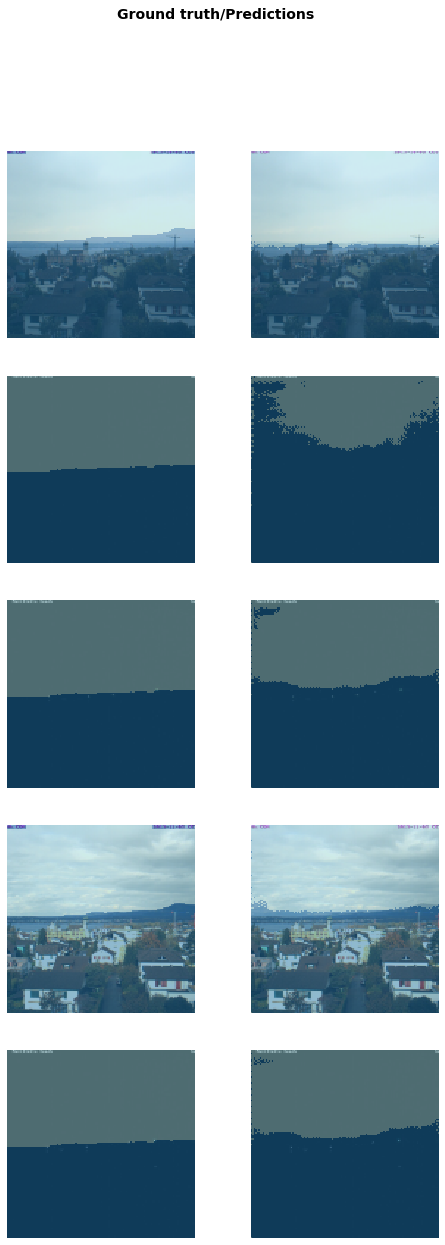

In [8]:
learner.show_results()

In [10]:
learner.save("/home/dmitri/Documents/model_weights/linknet34/unet34_wghts")
learner.export("/home/dmitri/Documents/model_weights/linknet34/unet34_exp")